<a href="https://colab.research.google.com/github/danieljai/CIND820-AndyLee/blob/main/AndyLee_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 3: Preload setup

Basic setup so results can utilize the full width of the screen.

In [3]:
%config IPCompleter.greedy=True
import pandas as pd

pd.set_option('display.max_colwidth', 200)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

# Step 4: Import Dataset

The hydrated file is stored in a Google Drive, and using the follow code will mount Google Drive onto Colaboratory.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/My Drive/__CIND 820 - Data Analytics Project/3-data/Book1-fastsave.csv")

# Step 5. Data Cleaning and Manipulation

## Preview data after cleaning and manipulation

Original Tweet dataframe datatypes

In [6]:
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/user-object
df.dtypes

coordinates                    object
created_at                     object
hashtags                       object
media                          object
urls                           object
favorite_count                  int64
id                              int64
in_reply_to_screen_name        object
in_reply_to_status_id         float64
in_reply_to_user_id           float64
lang                           object
place                          object
possibly_sensitive             object
retweet_count                   int64
retweet_id                    float64
retweet_screen_name            object
source                         object
text                           object
tweet_url                      object
user_created_at                object
user_screen_name               object
user_default_profile_image       bool
user_description               object
user_favourites_count           int64
user_followers_count            int64
user_friends_count              int64
user_listed_

## Readjust attribute datatype

For `retweet_id`, `in_reply_to_status_id`, `in_reply_to_user_id`
- Convert `null` values to 0
- Convert attribute as int64

In [7]:
df.retweet_id = df[df['retweet_id'].notnull()].retweet_id.astype('int64') 

In [8]:
df.retweet_id = df.retweet_id.fillna(0).astype('int64')
df.in_reply_to_status_id = df.in_reply_to_status_id.fillna(0).astype('int64')
df.in_reply_to_user_id = df.in_reply_to_user_id.fillna(0).astype('int64')

In [9]:
df[['text']].sample(10)

,text
785258,RT @JainGoldnMandir: A glimpse of selfless activities done by \nAmdavad Jain Tapovan during the crisis of Corona..\n\n*Jabardust Jaino ki Shas…
295900,@RamCNN What have you done to help with the Corona Virus other than feed your Trump Derangement Syndrome at your lame Network. You and Acosta giving each other hand jobs while you figure out ways to trash the President for saving lives? #enemyofthepeople
521616,@TeniEntertainer See Mary see jesus see baby see corona
688879,I now know 2 people who have lost a loved one to the Corona virus within the last 6 days
573766,RT @raga_with: Corona can also be treated but not the Godi media. \n#मीडिया_वायरस https://t.co/U1O9EufWCP
165295,RT @guyverhofstadt: We’ll overcome this Corona crisis as a society of free &amp; responsible people. Not because a wannabe dictator tells us to…
129568,@sagarikaghose Are you stupid or Corona has taken over your brain ? When they attended that function none aware of Kanika positiveness and this is something else for what you are comparing these two different scenarios ? Just like your glass you are also weird 😂🤣🙈🤦
698807,RT @ThuggerDaily: Tory Lanez asked Thug what he’s doing to avoid corona and this what he said 😂 https://t.co/b2ppVdVdWD
216952,"RT @RukmaniTomar: My son and other children, who are in Denipro, Ukraine for higher studies are stuck there alone due to this corona virus…"
99677,RT @Real_SureshBJP: @aniljaindr thank you very much to you and your entire family\nYou are the responsibility of an Indian citizen by donati…


## Misc. cleaning up to reduce noise when conducting sentimental analysis
1. remove \n
2. remove URL
3. remove user referrals
4. remove hashtags

In [10]:
df['modified_text'] = df.text.str.replace(r'\n', '')
df['modified_text'] = df.modified_text.str.replace(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '')
df['modified_text'] = df.modified_text.str.replace(r'\B@\w+', '')
df['modified_text'] = df.modified_text.str.replace(r'\B#\w+', '')

## Splitting Dataframes (originals and retweets)

The collection includes both original tweets and retweets. Since retweets mirrors the original tweet by someone else other than the author, we don't need to run sentimental analysis on the retweet as it would have been run on the original tweet, therefore we can split original tweets and retweets into two dataframes to avoid wasting resources.


- Original tweets: `dfOriginals`
- Retweets: `dfRetweets` cons





In [11]:
dfOriginals = df[df.retweet_id == 0]
dfRetweets = df[df.retweet_id != 0]

Two samples of the original tweet dataframe.

In [12]:
dfOriginals.sample(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,lang,place,possibly_sensitive,retweet_count,retweet_id,retweet_screen_name,source,text,tweet_url,user_created_at,user_screen_name,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified,modified_text
214559,NaN,Tue Mar 31 11:33:51 +0000 2020,NaN,NaN,NaN,0,1244951033887035394,rtenews,1244935699511554048,8973062,en,NaN,NaN,0,0,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",@rtenews This doesn't apply I assume if God forbid the deceased passed from Corona,https://twitter.com/Thehighstool/status/1244951033887035394,Mon Sep 07 18:48:43 +0000 2009,Thehighstool,False,"Meath Gaa fan, Liverpool fc fan, Darts fan & general sports nut",18995,275,5001,0,"Meath, Ireland",Keith Byrne,Thehighstool,191,NaN,NaN,False,This doesn't apply I assume if God forbid the deceased passed from Corona
186642,NaN,Tue Mar 31 10:46:56 +0000 2020,NaN,NaN,https://twitter.com/PoddarVaishali/status/1244920448413872128,9,1244939228477341702,NaN,0,0,en,NaN,False,2,0,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please let me know if you need volunteers in Pune area for noble work. https://t.co/9CwAPF4XTd,https://twitter.com/theogrishi/status/1244939228477341702,Tue Nov 26 10:20:43 +0000 2019,theogrishi,False,Adventure & Fitness Freak 🤓! Pune. Law. DM or Mail on one99notout@icloud.com,1226,70,255,0,"Pune, India",Rishi Bharadwaj,theogrishi,2106,NaN,http://www.instagram.com/theogrishi,False,Please let me know if you need volunteers in Pune area for noble work.


## Guessing language

Since our sentiment analysis focuses on only English tweets, we will install a `langdetect` library to help filter out tweets that are not English.

In [13]:
#https://pypi.org/project/langdetect/
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0



     |████████████████████████████████| 983kB 4.4MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=182cd2556d7f05819d22378c3da5907e0db645ae295fa54c4bf0cea197153bea
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


Function to test whether tweet is English with error handling.

In [14]:
#https://stackoverflow.com/questions/60930935/exclude-non-english-rows-in-pandas

def is_en(txt):
    try:
        return detect(txt)=='en'
    except:
        return False

Passing as the `is_en()` as first-class function; returning a boolean value as a attribute `guessed_language`.

In [15]:
dfOriginals['guessed_language'] = dfOriginals.modified_text.apply(is_en)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


By filtering out non-English tweets, we remove noise that can potentially affect our sentimental analysis.

In [16]:
print("There are " + str(len(dfOriginals)) + " tweets, and " + str(sum(dfOriginals.guessed_language)) + " ("+str(round((sum(dfOriginals.guessed_language) / len(dfOriginals)) * 100, 2))+"%) tweets detected as English.")

There are 245389 tweets, and 232816 (94.88%) tweets detected as English.


# Step 6. Sentiment Analysis

To conduct Seitment Analysis, we begin by importing the NLTK library.

In [17]:
import nltk
from nltk.sentiment.util import *
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk import tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Applying Sentiment Analysis function

We apply the polarity score function and store results on a new attribute `sentimentscore`.



In [18]:
dfOriginals['sentimentscore'] = dfOriginals.modified_text.apply(sid.polarity_scores)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


A quick sample preview of the text and its sentiment score.

In [19]:
dfOriginals.sample(2)[['modified_text','sentimentscore']]

,modified_text,sentimentscore
111395,Fuck corona let's have shots,"{'neg': 0.467, 'neu': 0.533, 'pos': 0.0, 'compound': -0.5423}"
496916,Corona why,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


The `SentimentIntensityAnalyzer()` returns a dictionary of scores negative, neutral, positive, and compound. Compound is the normalization of negative, neutral, and positive values.


How compound is calculated? https://stackoverflow.com/questions/40325980/how-is-the-vader-compound-polarity-score-calculated-in-python-nltk

Next, we expand the score, which is currently as dictionary, into their own attributes for better data manipulation--especially the compound attribute.

In [20]:
dfOriginalSScore = pd.json_normalize(dfOriginals.sentimentscore)
dfOriginalSScore['original_index'] = dfOriginals.index
dfOriginalSScore = dfOriginalSScore.set_index('original_index')

Merge the dataframe with sentiment scores and the dataframe with the original tweets together, onto a new dataframe `dfOriginals_Analyzed`.

In [21]:
dfOriginals_Analyzed = dfOriginals.merge(dfOriginalSScore, left_index=True, right_index=True)

Quick preview of modified text and compound on the merged dataframe.

In [22]:
dfOriginals_Analyzed.sample(10)[['modified_text','compound']]

,modified_text,compound
23868,"Now I've got a clean picture of who they are .For the first time they've bcome human! I've always thot they're superior,kupiga vifua duf! am going to do this &amp;that!Corona has humbled them,wameogopa,they can't talk! Matiangi ako?",0.5951
363861,now muslims so speak.cant tolerate if their religion is attacked for fault. Fake news start peddling to save them. Have u heard of Mohd. Saad of markaz saying what he said about corona. He said fake disease and qe shud meet more. U ppl cant digest any thing against religion.,-0.8271
646074,"So 100,000 people will likely die of corona virus in the US OR 250,000.....the reason for the large discrepancy? It depends highly on non-essentials staying home! So stay home.",-0.6360
707130,She is crying all this while.She want to know whether she can get any drug that can help her get fit. She believed she's a corona virus carrier.. Please u can help by suggesting the measures she can apply. 🙏,0.7506
265423,Rain rain and self quarantine at home unexpected and unbelievable situation @ Taxila,0.2023
95420,Prysmian Reduces Dividend Due to Corona Crisis -19,-0.6249
307453,"So with all this talk of the corona virus death and case numbers, I genuinely don’t look at them much. There’s almost no real statistical value in it when a great number aren’t tested. Even if they meet all criteria. And work in a hospital. This is how hard it was for someone:",0.1513
465395,Think people think the Corona covid-19 virus does not magically appear!!🇺🇸,0.0000
385221,These are bigger Virus to our nation than,0.0000
767694,"What we should have done is to ban all international flighrs since Feb 25 or atleast from corona affected countries like China, U.S, Italy, Saudi countries etc ,if no in allowed situation should be better than now",-0.2500


We binning based on compound scores
* -1 to -0.1 = negative 
* -0.1 to 0.1  = neutral
* 0.1 to 1 = positive

The threshold chosen is based on the paper "Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm"

Deo, G. S., Mishra, A., Jalaluddin, Z. M., & Mahamuni, C. V. (2020, September). Predictive Analysis of Resource Usage Data in Academic Libraries using the VADER Sentiment Algorithm. In 2020 12th International Conference on Computational Intelligence and Communication Networks (CICN) (pp. 221-228). IEEE.

https://www.researchgate.net/profile/Gouri_Deo/publication/342988903_Predictive_Analysis_of_Resource_Usage_Data_in_Academic_Libraries_using_the_VADER_Sentiment_Algorithm/links/5f1085a6a6fdcc3ed70bcf20/Predictive-Analysis-of-Resource-Usage-Data-in-Academic-Libraries-using-the-VADER-Sentiment-Algorithm.pdf



In [23]:
dfOriginals_Analyzed['sentiment_class_relaxed'] = pd.cut(dfOriginals_Analyzed['compound'], bins=[-1, -0.1, 0.1, 1], right=True, labels=['neg', 'neu', 'pos'])
dfOriginals_Analyzed.sentiment_class_relaxed.value_counts()

neg    89051
pos    84039
neu    72299
Name: sentiment_class_relaxed, dtype: int64

# Step 7. Basic Analysis

Observing the correlation between variables.

In [24]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']].corr()

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_followers_count,user_friends_count,user_listed_count
favorite_count,1.000000,0.908576,0.165683,-0.001108,0.015366,0.007852,0.165683,0.005575,0.051646
retweet_count,0.908576,1.000000,0.090025,-0.003071,0.015991,0.007261,0.090025,0.007084,0.039251
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,1.000000,0.032721,0.609057
compound,-0.001108,-0.003071,0.003693,1.000000,-0.022604,-0.028941,0.003693,-0.006560,0.000249
user_statuses_count,0.015366,0.015991,0.116452,-0.022604,1.000000,0.326723,0.116452,0.105958,0.128835
user_favourites_count,0.007852,0.007261,0.000535,-0.028941,0.326723,1.000000,0.000535,0.100920,0.016049
user_followers_count,0.165683,0.090025,1.000000,0.003693,0.116452,0.000535,1.000000,0.032721,0.609057
user_friends_count,0.005575,0.007084,0.032721,-0.006560,0.105958,0.100920,0.032721,1.000000,0.048344
user_listed_count,0.051646,0.039251,0.609057,0.000249,0.128835,0.016049,0.609057,0.048344,1.000000


In [25]:
dfOriginals_Analyzed[['favorite_count','retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,favorite_count,retweet_count,user_followers_count,compound,user_statuses_count,user_favourites_count,user_followers_count,user_friends_count,user_listed_count
count,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000,245389.00000
mean,9.52971,2.70475,9251.20519,-0.01655,27468.30799,18028.51423,9251.20519,1284.43071,34.64758
std,384.21091,122.27732,250678.23602,0.47919,75560.36124,39592.12977,250678.23602,10409.72569,680.04372
min,0.00000,0.00000,0.00000,-0.99520,1.00000,0.00000,0.00000,0.00000,0.00000
25%,0.00000,0.00000,64.00000,-0.39760,1156.00000,510.00000,64.00000,135.00000,0.00000
50%,0.00000,0.00000,331.00000,0.00000,6344.00000,4200.00000,331.00000,399.00000,1.00000
75%,1.00000,0.00000,1307.00000,0.36120,24616.00000,17807.00000,1307.00000,1038.00000,6.00000
max,108137.00000,35137.00000,62855265.00000,0.99190,4472178.00000,1254400.00000,62855265.00000,4322723.00000,202433.00000


Plot Distribution of sentiment scores

The histogram shows the distribution appears to have some modes, and rather symmetric.

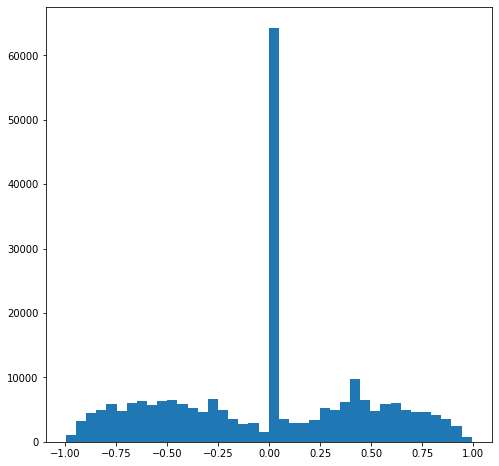

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,8)) 
histo_plot = plt.hist(dfOriginals_Analyzed['compound'],bins=40)


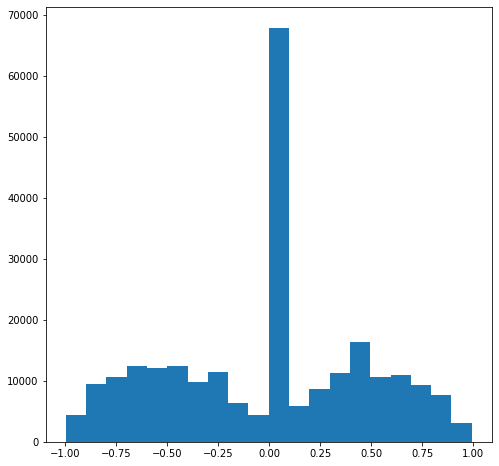

In [27]:
plt.figure(figsize=(8,8)) 
histo_plot2 = plt.hist(dfOriginals_Analyzed['compound'],bins=20)


(-1.1182944691568912,
 1.1129382929025038,
 -1.1162563432183583,
 1.1007741115818266)

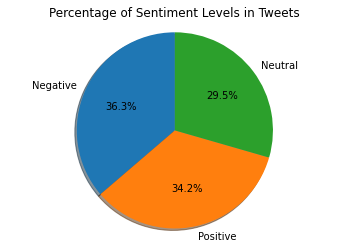

In [28]:
# Plot pie chart
# 

fig1, ax1 = plt.subplots()
ax1.pie(dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().values, labels=dfOriginals_Analyzed.sentiment_class_relaxed.value_counts().index.rename_categories(['Negative','Neutral','Positive']), autopct='%1.1f%%', shadow=True, startangle=90)
ax1.title.set_text("Percentage of Sentiment Levels in Tweets")
ax1.axis('equal')

# Step 8. Build Prediction Model for "Favourite Count" with Linear Regression

## Split Train and Test set

In [29]:
from sklearn import preprocessing
from sklearn import linear_model



independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


Coefficient	Label
 2.536713	retweet_count
 0.000211	user_followers_count
 1.016376	compound
-0.000038	user_statuses_count
 0.000057	user_favourites_count
-0.000056	user_friends_count
-0.034559	user_listed_count

R^2-score (train set): 0.799859


Since this is a regression model with continous values, we use Mean Square Error (MSE), Root MSE, and R-square metrics to measure the performance of the model. 

reference: https://stackoverflow.com/questions/49103139/calculating-accuracy-scores-of-predicted-continuous-values

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)

mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R^2:\t\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")




Metrics
Mean Square Error (MSE): 33404.189046
Root MSE:		 182.768129
Mean Absolute Error:	 7.281756
R^2:			 0.873217
Adjusted R-Square:	 0.873199


Scatterplot to visually observe how well the model's prediction vs actual value.

Text(0.5, 0, 'Actual values (retweet_count)')

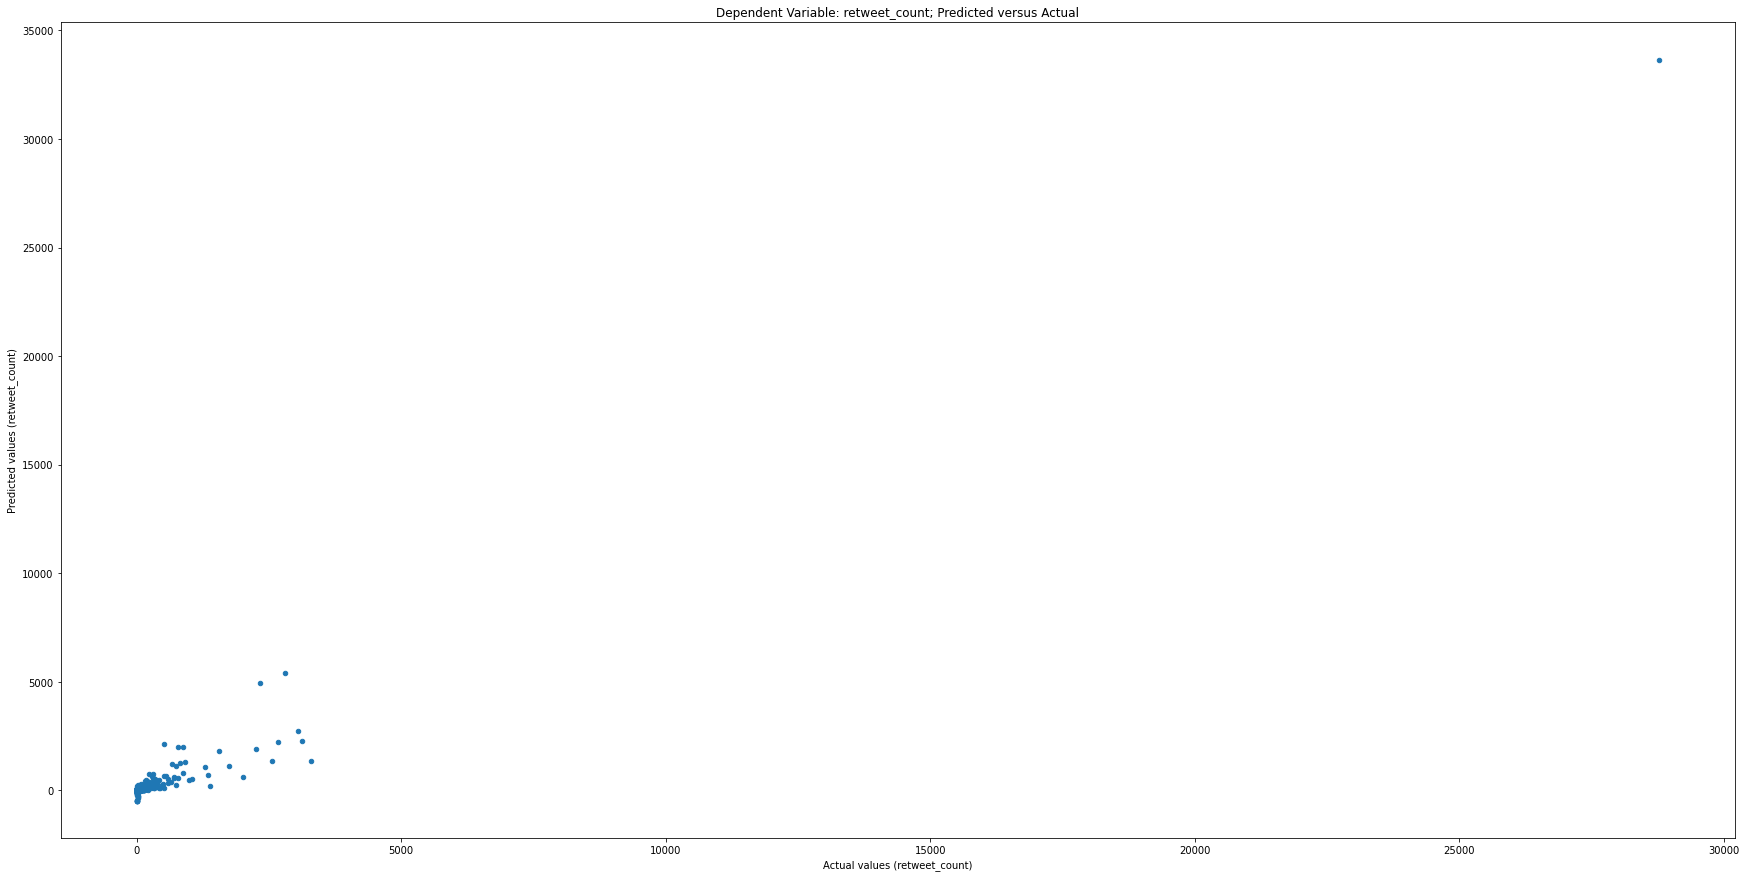

In [38]:
from numpy.polynomial.polynomial import polyfit
import numpy as np


plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")



Since our outliers are distorting the scatterplot visually, we will limit the observation to 2-sigma (95%).

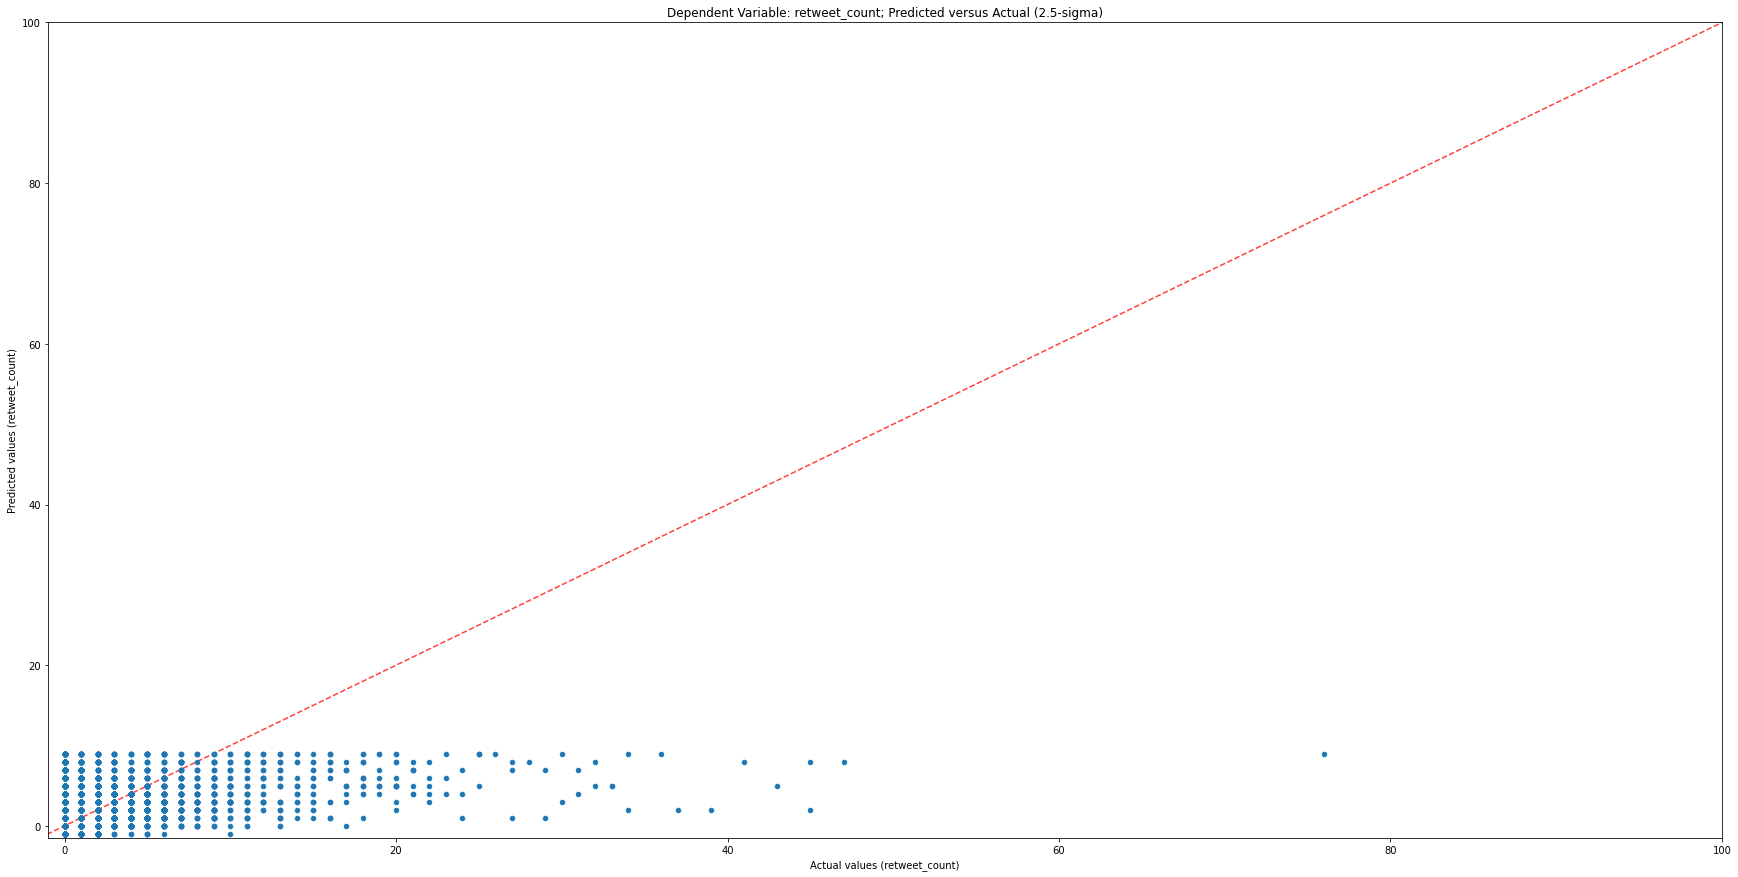

In [39]:
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.025), df_plot_1.predicted.quantile(0.975))]
# df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(0.0015), df_plot_1.predicted.quantile(0.9985))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")
plot_2.set_ylim(top=100)
plot_2.set_xlim(right=100)
plot_2.set_xlim(left=-1)




# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 9. Build Prediction Model for "Retweet Count" with Linear Regression

## Split Train and Test set

In [40]:
from sklearn import preprocessing
from sklearn import linear_model


# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'

# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

trainSet=dfOriginals_Analyzed.sample(frac=0.8,random_state=150)
testSet=dfOriginals_Analyzed.drop(trainSet.index)

X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]
reg = linear_model.LinearRegression()

reg.fit(X_train,Y_train)

# print("Coefficients: " + ', '.join(independent_variables))
# print(reg.coef_)
print('Coefficient\tLabel\n===========================================')
coefficient_list = (list(zip(reg.coef_, independent_variables)))
for el in coefficient_list:
  print('{: 4f}\t{}'.format(*el))

print(f"\nR^2-score (train set): {reg.score(X_train,Y_train):4f}")


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from math import sqrt

# Run prediction; Concating results onto a single dataframe; rounding prediction numbers as integer.
plot_1_Y = reg.predict(X_test) # predicted as Y
plot_1_X = Y_test.reset_index()  # actual as X
df_plot_1 = pd.concat([plot_1_X,pd.DataFrame(plot_1_Y)],axis=1)
df_plot_1.columns = ['index','actual', 'predicted']
df_plot_1.predicted = round(df_plot_1.predicted,0).astype(int)



mse = mean_squared_error(df_plot_1.actual, df_plot_1.predicted)
mae = mean_absolute_error(df_plot_1.actual, df_plot_1.predicted)
r2 = r2_score(df_plot_1.actual, df_plot_1.predicted)
adj_r2 = 1-(1-r2)*(len(df_plot_1.actual)-1)/(len(df_plot_1.actual)-len(independent_variables)-1)
print("\nMetrics\n============================================")
print(f"Mean Square Error (MSE): {mse:4f}")
print(f"Root MSE:\t\t {sqrt(mse):4f}")
print(f"Mean Absolute Error:\t {mae:4f}")
print(f"R-Square:\t\t {r2:4f}")
print(f"Adjusted R-Square:\t {adj_r2:4f}")


Coefficient	Label
 0.311235	favorite_count
-0.000055	user_followers_count
-0.449341	compound
 0.000013	user_statuses_count
-0.000014	user_favourites_count
 0.000025	user_friends_count
 0.009861	user_listed_count

R^2-score (train set): 0.791882

Metrics
Mean Square Error (MSE): 1234.588084
Root MSE:		 35.136706
Mean Absolute Error:	 1.967480
R-Square:		 0.934187
Adjusted R-Square:	 0.934178


Scatterplot of Predicted value vs Actual Value.

In [41]:
(sum((df_plot_1.actual - df_plot_1.predicted) ** 2)) / len(df_plot_1.actual)

1234.5880842740128

Text(0.5, 0, 'Actual values (retweet_count)')

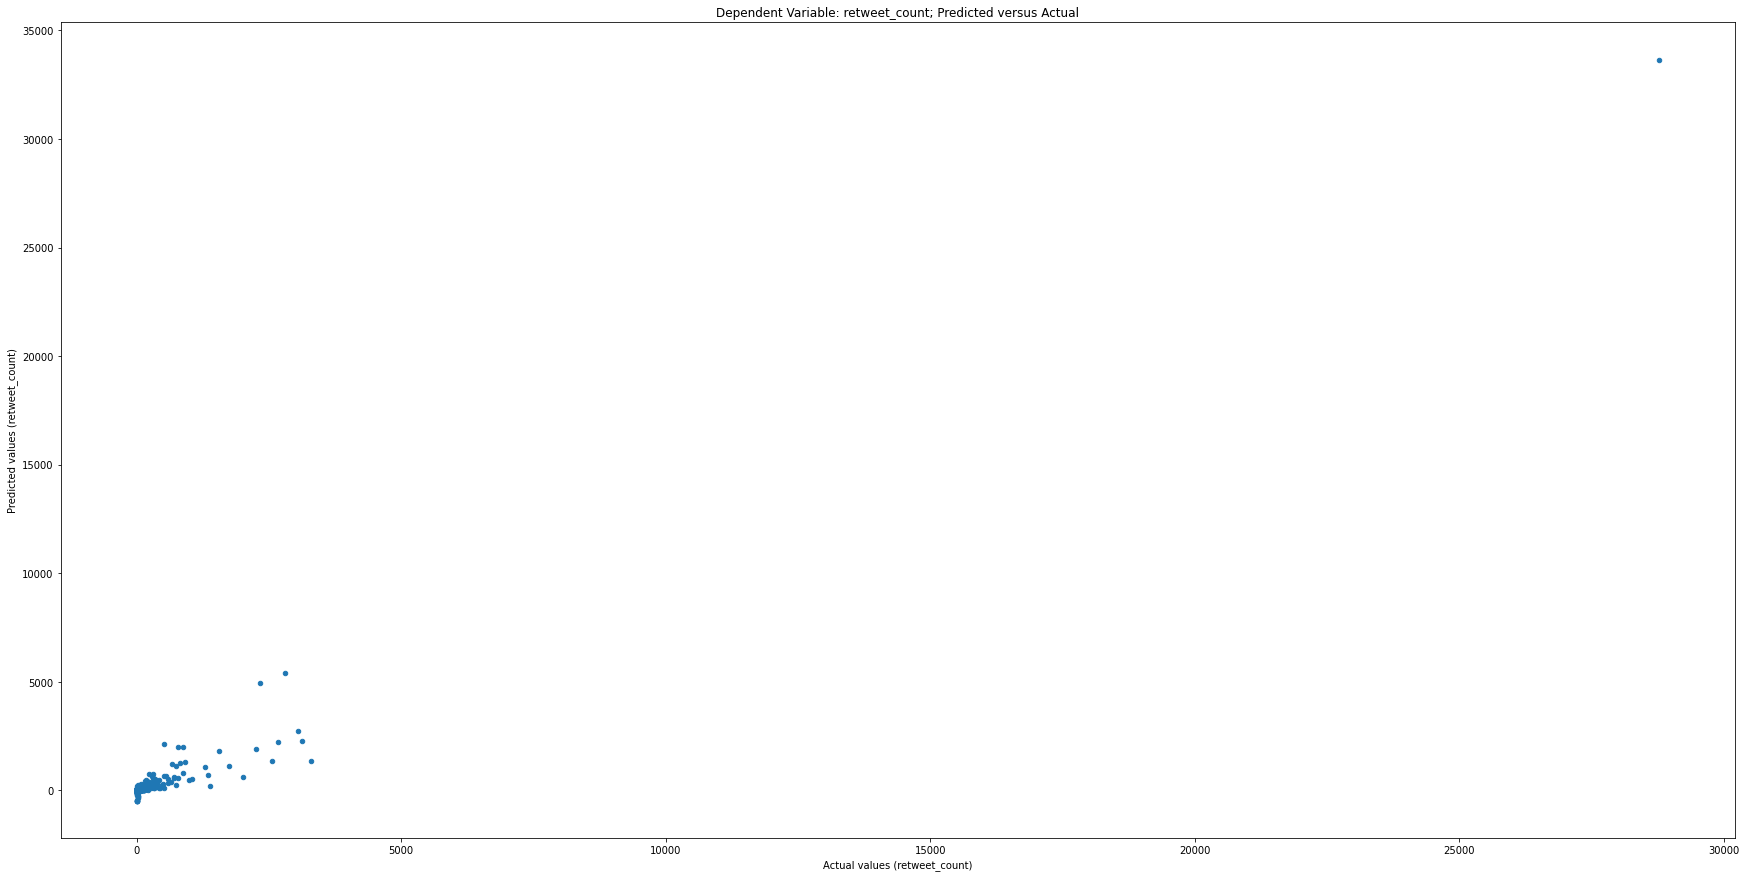

In [42]:
from numpy.polynomial.polynomial import polyfit

plot_1 = df_plot_1.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual")
plot_1.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_1.set_xlabel("Actual values (" + dependent_variables + ")")




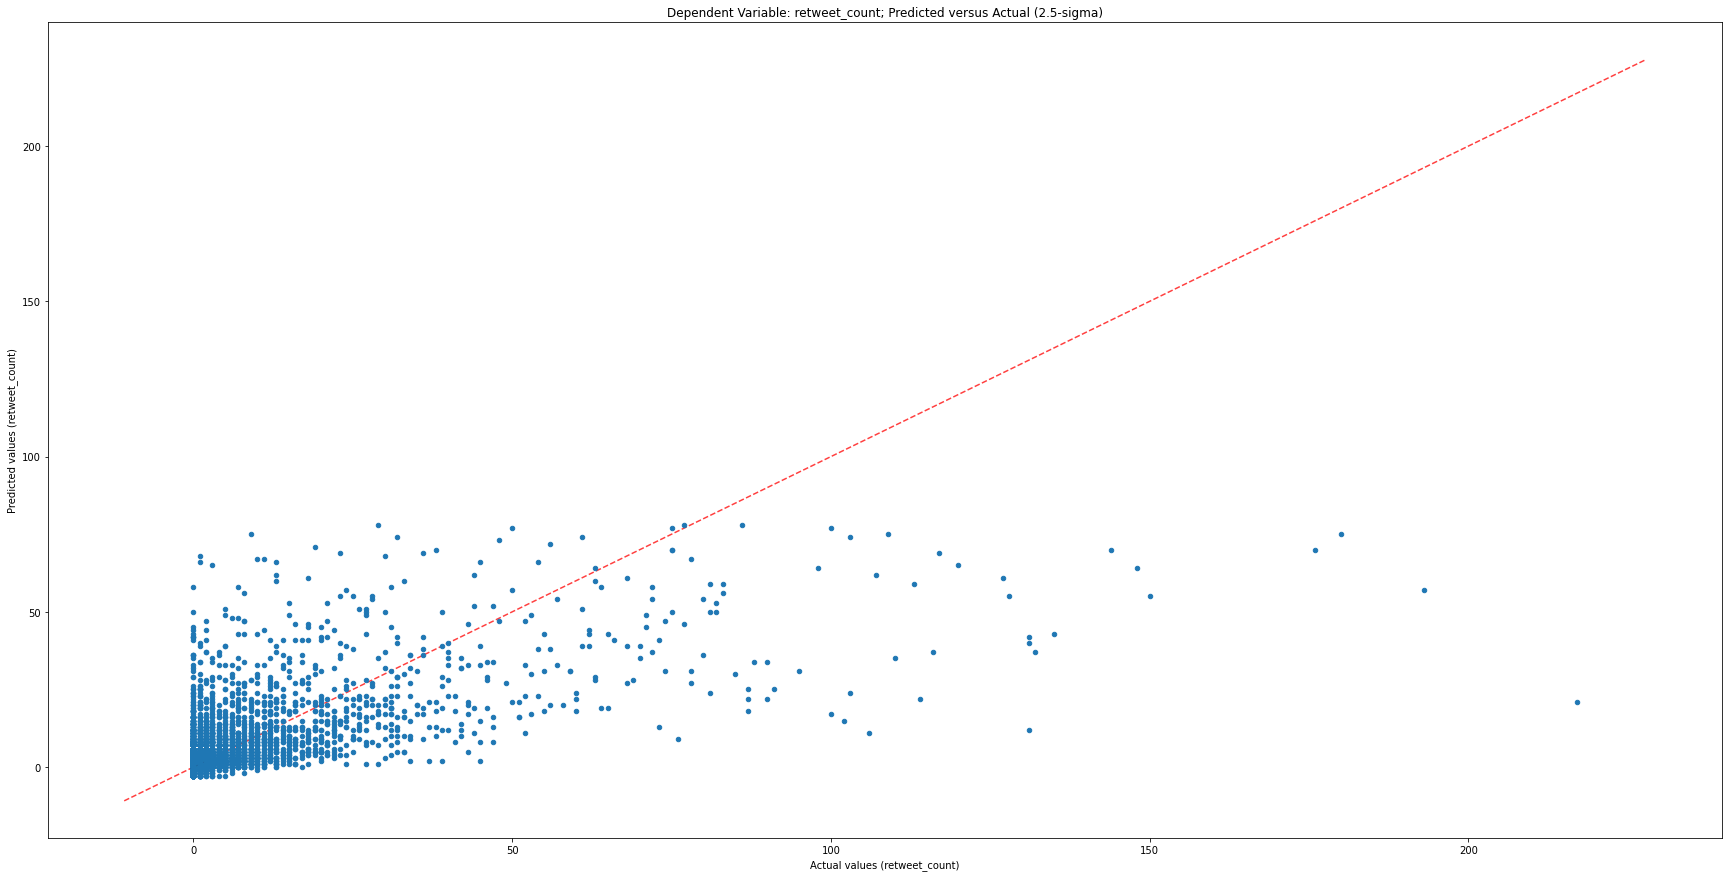

In [43]:
# Scatterplot covering 2.5-sigma.
df_plot_2 = df_plot_1[df_plot_1.predicted.between(df_plot_1.predicted.quantile(.0031), df_plot_1.predicted.quantile(0.9969))]
plot_2 = df_plot_2.plot.scatter(x='actual',y='predicted',figsize=(30,15),title="Dependent Variable: " + dependent_variables + "; Predicted versus Actual (2.5-sigma)")
plot_2.set_ylabel("Predicted values (" + dependent_variables + ")")
plot_2.set_xlabel("Actual values (" + dependent_variables + ")")

# b, m = polyfit(df_plot_2.actual, df_plot_2.predicted, 1)
# plot_2.plot(df_plot_2.actual, b + m * df_plot_2.actual, '-')

lims = [
    np.min([plot_2.get_xlim(), plot_2.get_ylim()]),  # min of both axes
    np.max([plot_2.get_xlim(), plot_2.get_ylim()]),  # max of both axes
]
plot_2.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

# Step 10: Linear Regression with K-fold

Since the metrics we got from the previous regression consist of only one sampling, we should implement the same regression model using K-fold cross-validation in order to get more accurate metrics.

In [82]:
# K-fold - #1 favourite count as dependent
#
# References:
# https://stackoverflow.com/questions/45115964/separate-pandas-dataframe-using-sklearns-kfold
# https://stackoverflow.com/questions/57398411/next-always-gives-the-same-index-with-a-kfold-generator
# https://machinelearningmastery.com/k-fold-cross-validation/
# https://machinelearningmastery.com/robust-regression-for-machine-learning-in-python/
from sklearn.model_selection import KFold

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_friends_count','user_listed_count']
dependent_variables = 'favorite_count'


kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Mean Square Error (MSE)\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)
  # print("Mean Square Error (MSE): " + str(mse))
  # print("Root MSE: " + str(sqrt(mse)))
  # print("R-Square: " + )

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")




Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
Mean Square Error (MSE)		Root MSE			R-Square
31564.218170		177.663216		0.877825
10521.044828		102.572145		0.704872
130028.329157		360.594411		0.378130
10211.723622		101.053073		0.782832
13119.346895		114.539718		0.930201

Average
39088.932535		171.284512		0.734772


In [83]:
# K-fold #2 Retweet as independent
#

from sklearn.model_selection import KFold


independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_favourites_count','user_followers_count','user_friends_count','user_listed_count']
dependent_variables = 'retweet_count'

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = 0, 0, 0
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

dfKfold = dfOriginals_Analyzed

kf_result = kf.split(dfKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Mean Square Error (MSE)\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfKfold.iloc[train_idx]
  testSet=dfKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  reg.fit(X_train,Y_train)

  y_test_pred = reg.predict(X_test) 

  mse = mean_squared_error(Y_test, y_test_pred)
  rsqr = r2_score(Y_test, y_test_pred)

  print(f"{mse:4f}\t\t{sqrt(mse):4f}\t\t{rsqr:4f}")

  kfold_mse_total += mse
  kfold_rmse_total += sqrt(mse)
  kfold_rsqr_total += rsqr

print("\nAverage\n=============================================================================================")
print(f"{kfold_mse_total / kfold_n:4f}\t\t{kfold_rmse_total / kfold_n:4f}\t\t{kfold_rsqr_total / kfold_n:4f}")





Dependent Variable: retweet_count
Independent Variables: ['favorite_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_favourites_count', 'user_followers_count', 'user_friends_count', 'user_listed_count']
K-fold: 5
Mean Square Error (MSE)		Root MSE			R-Square
1000.984587		31.638340		0.945595
798.111384		28.250865		0.605363
10974.758804		104.760483		0.685319
726.632995		26.956131		0.751255
668.976723		25.864584		0.959550

Average
2833.892899		43.494081		0.789416


# Step 11: Polynomial Regression

Here we attempt to fit our model onto a non-linear regression model--Polynomial regression model to see whether we are able to build a better fit of the model than linear regression.

R-squared values: 

Polynomial degree 1: test score=0.87
Polynomial degree 2: test score=0.72
Polynomial degree 3: test score=-5.57
Polynomial degree 6: test score=0.11


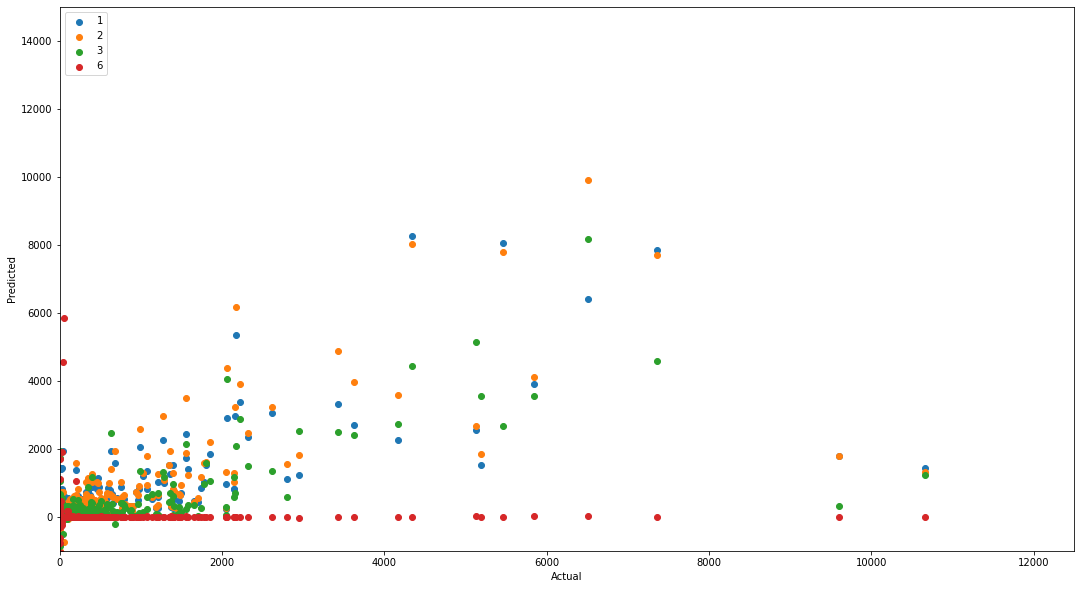

In [51]:
# POLYNOMIAL REGRESSION #1 favorite_count
#
#
# Reference
# https://www.kaggle.com/jnikhilsai/cross-validation-with-linear-regression

import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

R-squared values: 

Polynomial degree 1: test score=0.94
Polynomial degree 2: test score=0.08
Polynomial degree 3: test score=0.01
Polynomial degree 6: test score=-422.7


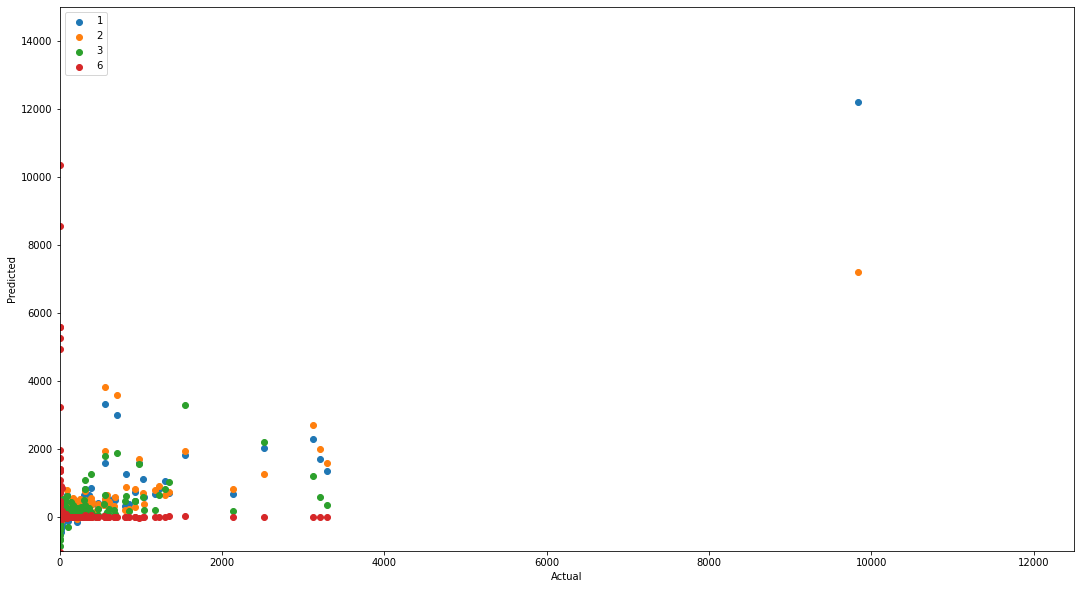

In [52]:
# POLYNOMIAL REGRESSION #2 retweet_count
#

# independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'favorite_count'
independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'retweet_count'
degrees = [1, 2, 3, 6]

# excluding Outliners
# dfPoly = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPoly = dfOriginals_Analyzed

trainSet=dfPoly.sample(frac=0.8,random_state=200)
testSet=dfPoly.drop(trainSet.index)


X_train = trainSet[independent_variables]
Y_train = trainSet[dependent_variables]
X_test = testSet[independent_variables]
Y_test = testSet[dependent_variables]

# y_train_pred = np.zeros((len(X_train), len(degrees)))
y_test_pred = np.zeros((len(X_test), len(degrees)))

# calculate values for each degree
for i, degree in enumerate(degrees):    
    # make pipeline: create features, then feed them to linear_reg model
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    
    # predict on test and train data
    # store the predictions of each degree in the corresponding column
    # y_train_pred[:, i] = model.predict(X_train)
    y_test_pred[:, i] = model.predict(X_test)
  
# plot the graph
plt.figure(figsize=(40, 10))
plt.subplot(121)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.ylim([-1000,15000])
plt.xlim([0,12500])
for i, degree in enumerate(degrees):    
    plt.scatter(Y_test, y_test_pred[:, i], label=str(degree))
    plt.legend(loc='upper left')


# print metrics
print("R-squared values: \n")

for i, degree in enumerate(degrees):
    # train_r2 = round(sklearn.metrics.r2_score(y_train, y_train_pred[:, i]), 2)
    test_r2 = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    print("Polynomial degree {0}: test score={1}".format(degree, test_r2))

# Polynomial Regression K-fold

In [206]:
import math

independent_variables = ['retweet_count','user_followers_count','compound','user_statuses_count','user_verified']
dependent_variables = 'favorite_count'
# independent_variables = ['favorite_count','user_followers_count','compound','user_statuses_count','user_verified']
# dependent_variables = 'retweet_count'
# degrees = [1, 2 ]
degrees = [1, 2, 3, 6]
count = 0

kfold_n = 5
kfold_mse_total, kfold_rmse_total, kfold_rsqr_total = pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees),pd.DataFrame(0, index=np.arange(kfold_n), columns=degrees)
kf = KFold(n_splits = kfold_n, shuffle = True, random_state = 2)

# Excluding outliers, only including within 3-sigma
# dfKfold = dfOriginals_Analyzed[dfOriginals_Analyzed[dependent_variables].between(dfOriginals_Analyzed[dependent_variables].quantile(.0015), dfOriginals_Analyzed[dependent_variables].quantile(0.9985))]
dfPolyKfold = dfOriginals_Analyzed

kf_result = kf.split(dfPolyKfold)

print("Dependent Variable: {}".format(dependent_variables))
print("Independent Variables: {}".format(independent_variables))
print("K-fold: {}".format(kfold_n))
print("Polynomial\t\tRoot MSE\t\t\tR-Square\n=============================================================================================")

for train_idx, test_idx in kf_result:
  # print(train_idx)
  trainSet=dfPolyKfold.iloc[train_idx]
  testSet=dfPolyKfold.iloc[test_idx]

  X_train = trainSet[independent_variables]
  Y_train = trainSet[dependent_variables]
  X_test = testSet[independent_variables]
  Y_test = testSet[dependent_variables]

  reg = linear_model.LinearRegression()

  y_test_pred = np.zeros((len(X_test), len(degrees)))

  for i, degree in enumerate(degrees):    
    model = make_pipeline(PolynomialFeatures(degree), linear_model.LinearRegression())
    model.fit(X_train, Y_train)
    

    y_test_pred[:, i] = model.predict(X_test)

  
  
  for i, degree in enumerate(degrees):
    
    rsqr = round(r2_score(Y_test, y_test_pred[:, i]), 2)
    mse = mean_squared_error(Y_test, y_test_pred[:, i])
    print("Degree {0}: \t\t{1} \t\t{2}".format(degree, sqrt(mse),rsqr))
    row = math.floor(count/len(degrees))
    kfold_mse_total.loc[ row,degree ] = mse
    kfold_rmse_total.loc[ row,degree] = sqrt(mse)
    kfold_rsqr_total.loc[row,degree] = rsqr
    # print(f"count: {count}  row: {row}\n{kfold_rsqr_total.loc[row]}")
    count += 1
    


  print("---------------------------------------------------------------------------------")



print("\nAverage\n=============================================================================================")
# for i, degree in enumerate(degrees):
print(f"MSE Mean: \n{kfold_mse_total.mean()}")
print(f"RMSE Mean: \n{kfold_rmse_total.mean()}")
print(f"R^2 Mean: \n{kfold_rsqr_total.mean()}")




Dependent Variable: favorite_count
Independent Variables: ['retweet_count', 'user_followers_count', 'compound', 'user_statuses_count', 'user_verified']
K-fold: 5
Polynomial		Root MSE			R-Square
Degree 1: 		176.1003309179579 		0.88
Degree 2: 		283.8671924780902 		0.69
Degree 3: 		906.2368606263769 		-2.18
Degree 6: 		856.3979925552468 		-1.84
---------------------------------------------------------------------------------
Degree 1: 		101.57117876732413 		0.71
Degree 2: 		113.61553501192776 		0.64
Degree 3: 		164.8107158447843 		0.24
Degree 6: 		1067.8173629126154 		-30.98
---------------------------------------------------------------------------------
Degree 1: 		361.7648735168686 		0.37
Degree 2: 		578.1225176563707 		-0.6
Degree 3: 		10089.810890024544 		-485.89
Degree 6: 		38011377.335343964 		-6910168447.01
---------------------------------------------------------------------------------
Degree 1: 		106.07747474685985 		0.76
Degree 2: 		132.28407898975604 		0.63
Degree 3: 		429.97

In [223]:
kfold_rsqr_total.mean()

1    7.300000e-01
2    3.860000e-01
3   -1.005020e+02
6   -1.382036e+09
dtype: float64

In [219]:
polykfold_overall_metrics = list(zip(degrees,kfold_rmse_total.mean(),kfold_rsqr_total.mean()))
print('Degree\tAverage RMSE\tAverage R^2'.format(*el))
for el in polykfold_overall_metrics:
  print('{}\t{: 4f}\t{: 4f}'.format(*el))

Degree	Average RMSE	Average R^2
1	 171.732444	 0.730000
2	 278.427035	 0.386000
3	 2627.819479	-100.502000
6	 7610133.839796	-1382035952.734000


# Further Attempts

- Groupby user_screen_name
- calculate the mean sentiment score
- see whether there are any correlation between number of followers and number of favourite tweets against the mean sentimental score (check SD)

explain properly an understanding of why introducing new feature

In [ ]:
dfOriginals.groupby('user_screen_name').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

## Notes from last meeting
is final results due next monday

[link text](https://)
* is the level of detailness enough for the steps?
* any metrics i still need?
* is next week's due date include the presentation?
* is there any specific dates to when the presentation will be.
* updated plot, outlier
* update graph to exclude
* have linear model, but also run another non-linear model
* set xlim and ylim
* removing outlier using SD central tendencies (or visual 3 SD away)
* - non linear regression
* - scale x and y axis
* polynomial regression models
* word doc make reference 